In [1]:
import pandas as pd
import numpy as np

# Operating System
import os

# https requests
import requests

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import Functions that we will be using

In [3]:
# Receives df_main, sums across states, and returns DataFrame with just the last day

def build_single_day_df(df_main, day_to_use=None):

    # Create new DataFrame for country-level analysis
    df_today = df_main.copy()
    
    # Aggregates suming the values for different states
    df_today = df_today.groupby(level = ['country', 'date']).sum().sort_index()

    # Drop unused columns
    df_today = df_today.drop(columns=['lat', 'long'])
    
    # Keep a signle date in the dataframe
    if day_to_use is None:
        day_to_use = df_today.index.get_level_values('date').max()
    

    idx = pd.IndexSlice
    df_today = df_today.loc[idx[:,day_to_use], :]    
    
    return df_today

In [4]:
# Receives df_main, sums across states, and returns DataFrame with just the last day

def build_single_country_df(df_main, country=None):
    
    # Create new DataFrame for single coubtry analysis
    df_country = df_main.copy()
    
    # Aggregates suming the values for different states
    df_country = df_country.groupby(level = ['country', 'date']).sum().sort_index()
    
    # Drop unused columns
    df_country = df_country.drop(columns=['lat', 'long'])
    
    # If a country was not provided retur None
    if country is None:
        return None
    
    # Keep a signle country in the dataframe and remove first two dates
    
    # Because of the .diff() operator, the faetures 'new_infections' and 'new_infections_increase'
    # have values of the previous country in the first two dates available for each country.
    first_date_to_use = df_country.index.get_level_values('date').min() + pd.Timedelta(days=2)
    
    idx = pd.IndexSlice
    df_country = df_country.loc[idx[country, first_date_to_use:], :] 
    
    return df_country


In [5]:
# Prints Last Day View plots 

def plot_today_figures(df_today, var_to_plot, pop=None, num_countries=10, min_pop = 1):
    
    df_plot = df_today[[var_to_plot]].copy()
    
    # save the last date and drop date index
    last_date_str = df_plot.index.get_level_values('date').max().strftime("%d-%b-%Y") 
    df_plot = df_plot.reset_index(level='date', drop=True)
    
    if pop is not None:
        
        # validade population DataFrame
        assert isinstance(pop, pd.DataFrame)
        assert pop.index.name == 'country'
        assert 'million_people' in pop.columns
        
        # merge with COVID DataFrame
        df_plot = pd.merge(df_plot, pop, how='inner', on='country', validate='one_to_one')
        
        # Create variable to plot formatted with correct units
        df_plot['plot_this'] = df_plot[var_to_plot] / df_plot['million_people']
        
        # Drop countries with less than min_pop population
        df_plot = df_plot.loc[df_plot.million_people > min_pop,:]
        
    else:
        df_plot['plot_this'] = df_plot[var_to_plot]

    
    
    # select top countries
    top_list = df_plot.loc[:, 'plot_this'].sort_values(ascending=False).iloc[:num_countries].index.tolist()
    
    if "portugal" not in top_list:
        top_list.append("portugal")
    
    # Format plot title
    plot_title_str = '{} on {}'.format(var_to_plot, last_date_str).replace('_', ' ').capitalize()
    if 'increase' in plot_title_str:
        plot_title_str += ' from previous day value' 
    
    # Format ylabel
    if pop is not None:
        y_lab = 'per million people'
    else:
        y_lab = 'total'
    
    # Format plot file name
    file_name_str = var_to_plot + '_' + y_lab.replace(' ', '_')
    
    # Plot
    df_plot.loc[top_list, ['plot_this']].plot.bar(figsize=(8,4))
    
    plt.grid(axis='y')
    plt.legend('')

    plt.title(plot_title_str)
    plt.ylabel('[{}]'.format(y_lab))
    plt.xticks(rotation=25)
    
    plt.savefig(os.path.join('plots', file_name_str));

    
    return df_plot, top_list

In [6]:
def plot_country_figures(df_country, 
                         min_num_cases = 100,
                         var_to_plot='new_infections', 
                         log=True, 
                         pct_change=False, 
                         rolling=7):
    
    df_plot = df_country.copy()
    
    # Record the date when the number of comfirmed cases exceeds the minimum number of cases (min_num_cases)
    first_date = df_plot.loc[ df_plot.total_infections > min_num_cases, :].index.get_level_values('date')[0]
    
    # Save country name and remove it from the DataFrame index
    country_name = df_plot.index.get_level_values('country')[0]
    
    if var_to_plot is None:
        print("plot_country_figures(): no variable was defined")
        return
    
    # Save a new time series with the variable to plot
    df_plot = df_plot.reset_index(level='country', drop=True)
    ts = df_plot[var_to_plot]
    
    # We assume that when the variable takes the value zero it means missing
    ts = ts.replace(to_replace=0, value=np.nan)
    
    # Format plot title and y axis label
    plot_title_str = var_to_plot 
    y_lab = ""
    
    if pct_change == True:
        ts = ts.pct_change().multiply(100)
        
        # we assum more than 500% increase is an error in reporting
        ts[ts > 500] = np.nan
        
        plot_title_str += " growth rate"
        y_lab = "[%]"
        # if pct_change is True, then it makes no sense to use log scale
        log = False
        
        if rolling > 1:
            ts = ts.rolling(rolling, min_periods=1).mean()

            plot_title_str += " ({} days moving average)".format(rolling)
    
    
    plot_title_str = plot_title_str.replace('_', ' ').capitalize()
    plot_title_str += " in {}".format(country_name.upper())
    
    # Format ylabel
    if log == True:
        y_lab = '[log. scale]'  
    
    
    ts[first_date:].plot(figsize=(8,4), marker='D', markersize=4, logy=log)

    plt.grid(axis='y')
    plt.legend('')

    plt.title(plot_title_str)
    plt.ylabel(y_lab)
    plt.show();
    
    return ts

In [7]:
# read world population DataFrame
df_population = pd.read_pickle('./data/df_population.pkl')

In [8]:
# read the complete COVID DataFrame
df_main = pd.read_pickle('./data/df_main.pkl')

In [9]:
idx = pd.IndexSlice

In [10]:
# Record last available date
last_date = df_main.index.get_level_values('date').max()

### Data Source

We have used [this data source](https://github.com/datasets/covid-19), which is itself an aggregation repository from different sources. The data was then processed and the plots presented below were made from a csv main file available [here](https://github.com/jnpicao/covid-19/blob/master/data/covid_panel_data_aggregation.csv).

# Worldwide Day Summary

In [11]:
# Can test the output by changing the date
# df_world_today = df_main.loc[idx[:, :,"2020-03-21"], :].sum().drop(['lat', 'long'])
df_world_today = df_main.loc[idx[:, :,last_date], :].sum().drop(['lat', 'long'])
#df_world_today

In [12]:
str_to_print = "On {} there were {:,.0f} new infections reported worldwide, an increase of {:,.0f} new infections from the previous day, and {:,.0f} people died."
format_parameters_list = [last_date.strftime("%d-%b-%Y"), 
                          df_world_today['new_infections'],
                          df_world_today['new_infections_increase'],
                          df_world_today['new_deaths']
                         ]

print(str_to_print.format(*format_parameters_list))

On 30-Mar-2020 there were 62,248 new infections reported worldwide, an increase of 2,837 new infections from the previous day, and 3,657 people died.


In [13]:
str_to_print = "Until {}, {:,.0f} people have been reported infected, and {:,.0f} people have died."
format_parameters_list = [last_date.strftime("%d-%b-%Y"), 
                          df_world_today['total_infections'],
                          df_world_today['total_deaths']
                         ]

print(str_to_print.format(*format_parameters_list))

Until 30-Mar-2020, 782,365 people have been reported infected, and 37,582 people have died.


# Last Day View

In [14]:
# Build today country-level DataFrame
df_today = build_single_day_df(df_main)

In [15]:
list_of_countries = ["portugal", "spain", "italy"]

# # Uncomment to confirm results
# df_main.loc[idx[list_of_countries, :, last_date - pd.Timedelta(days=2) :last_date], :]

In [16]:
# # Uncomment to confirm results
# df_today.loc[idx[list_of_countries,:],:]

## New Infections  

This variable describes the flow of people into the *infected reservoir*, i.e. how many people a day are testing positive for the infection. It assesses the *speed* people are entering into the *infected pool*.

In each plot, we include the top-10 countries plus Portugal (if not in the top-10).

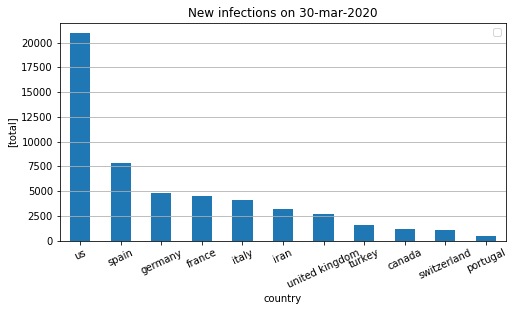

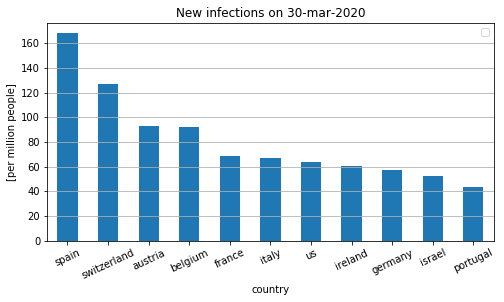

In [17]:
var_to_plot = 'new_infections'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)

## New Infections Increase  

To assess whether the number of people in the *infected reservoir* is increasing or decreasing, a better proxy is the variation of the previous variable.  

Every new infection will, sooner or later, leave the *infected pool* (either by recover or death). In this way, if the number of new infections stabilizes, the same will happen, sooner or later, to the total number of people in the *infected reservoir*.


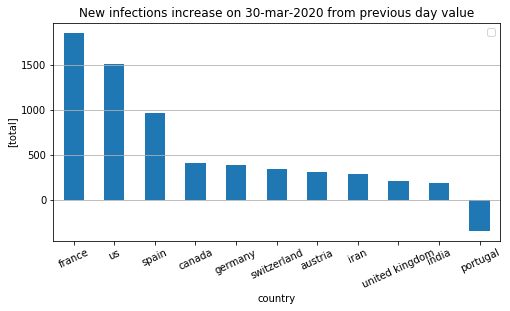

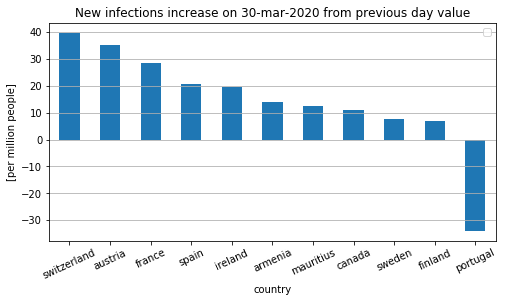

In [18]:
var_to_plot = 'new_infections_increase'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)

# Aggregate Total View  

The total number of infections and deaths, until the last available date.

## Total Number of Infections

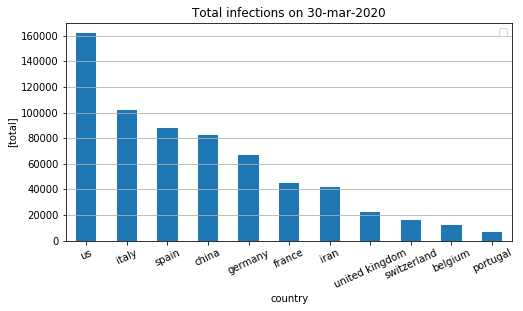

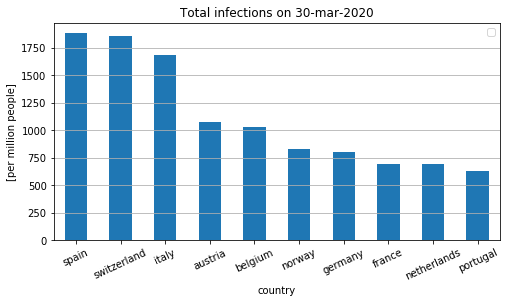

In [19]:
var_to_plot = 'total_infections'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)


## Total Number of Deaths

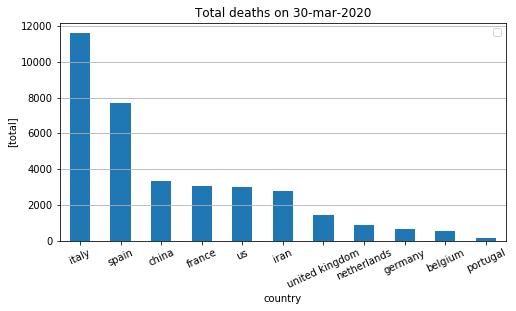

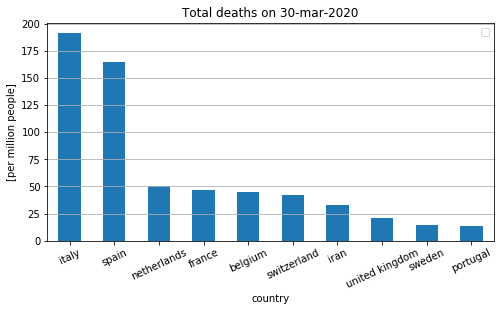

In [20]:
var_to_plot = 'total_deaths'
for population in [None, df_population]:
    plot_today_figures(df_today, var_to_plot, pop=population)

# Single Country Time Series  

For a select list of countries, where the infection is most active, we present the evolution (time series) since the day of the 100th reported infection using the following plots:
* New infections (with logarithmic scale)
* New infections rate of growth (i.e., percentage change since last day), simple and 6 day moving average.


Note: increases greater than 500% were ignored.

In [21]:
param_list = ([{'log': True, 'pct_change': False, 'rolling': 0},
               {'log': False, 'pct_change': True, 'rolling': 0}, 
               {'log': False, 'pct_change': True, 'rolling': 6}])

## Portugal

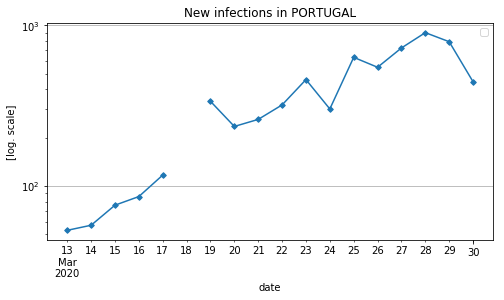

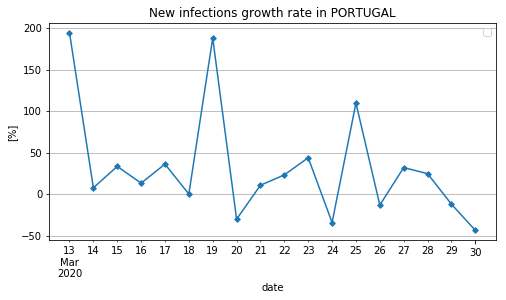

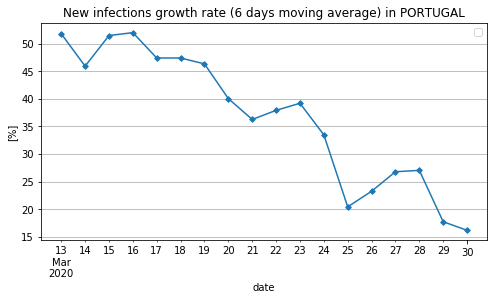

In [22]:
country = "portugal"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## United States

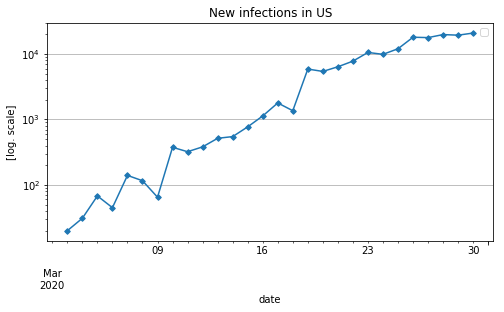

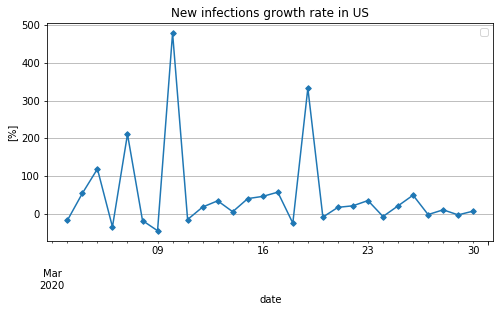

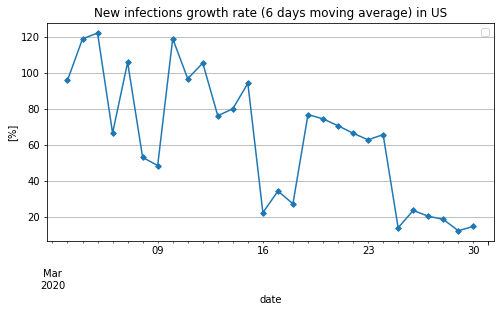

In [23]:
country = "us"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## Spain

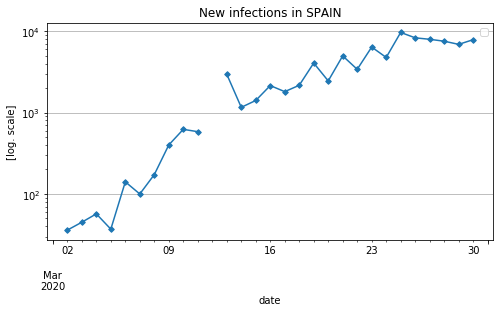

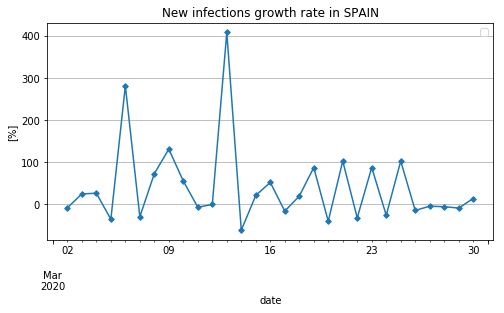

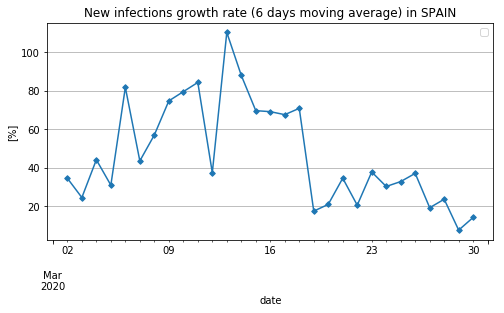

In [24]:
country = "spain"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## Italy

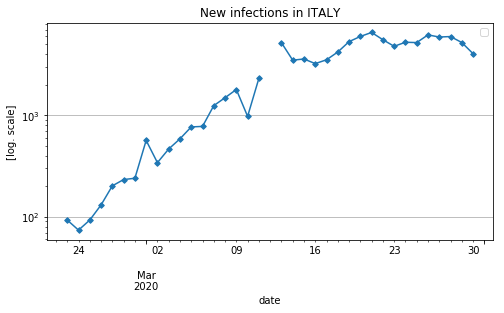

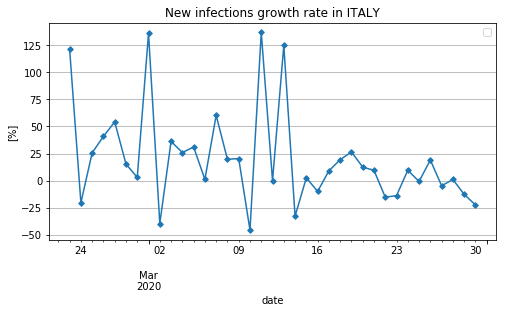

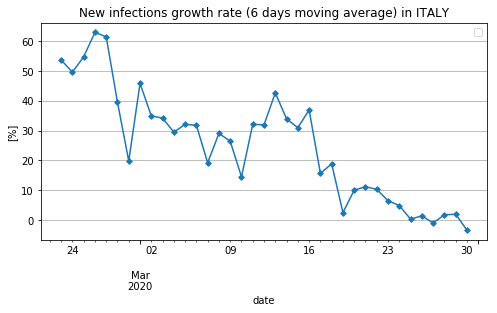

In [25]:
country = "italy"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## France

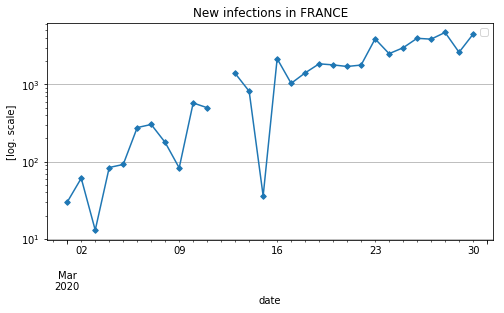

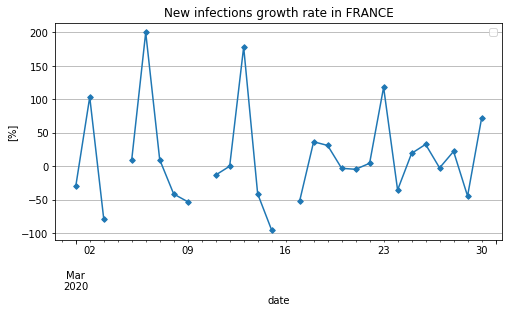

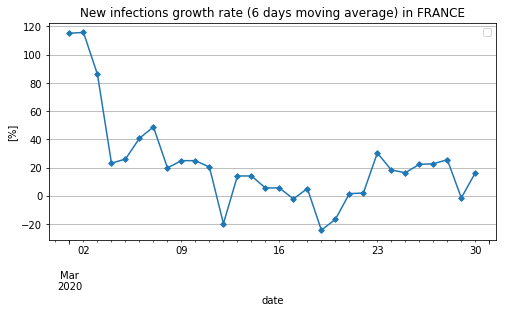

In [26]:
country = "france"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## United Kingdom

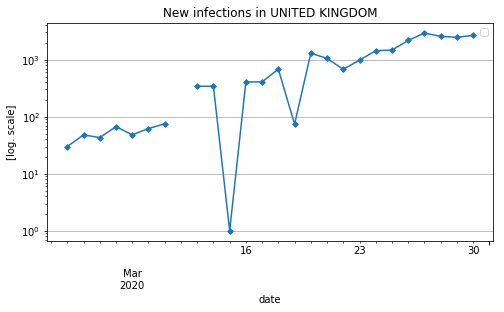

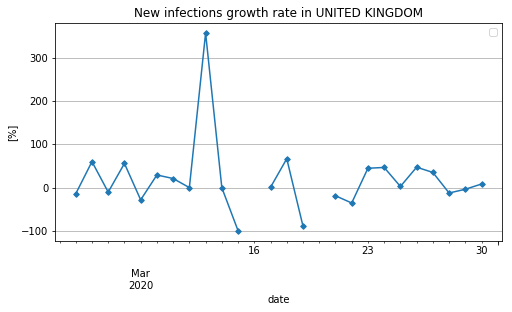

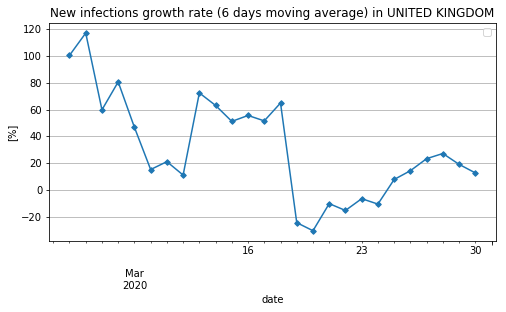

In [27]:
country = "united kingdom"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## Netherlands

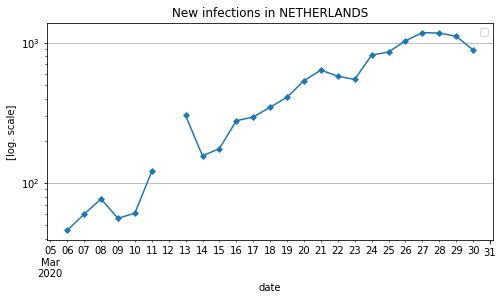

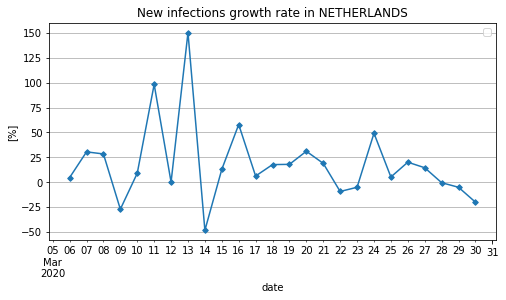

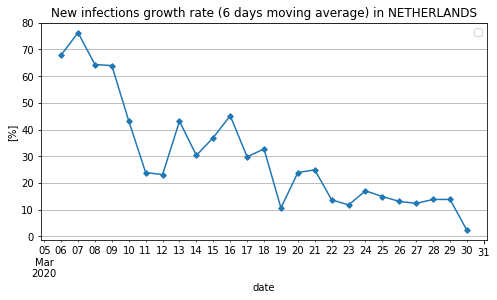

In [28]:
country = "netherlands"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## Switzerland

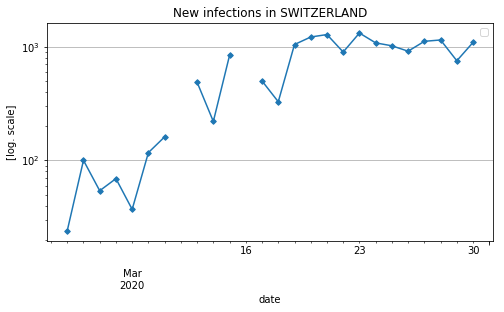

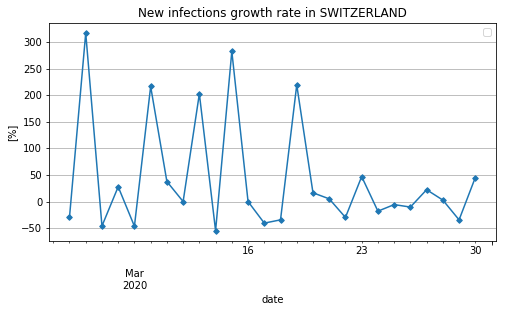

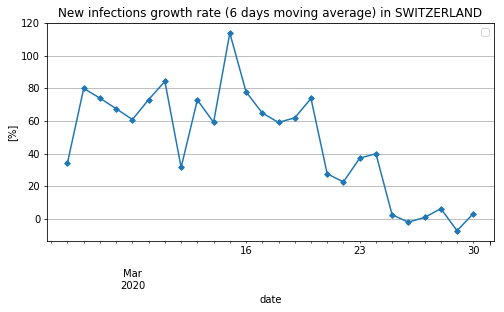

In [29]:
country = "switzerland"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## Iran

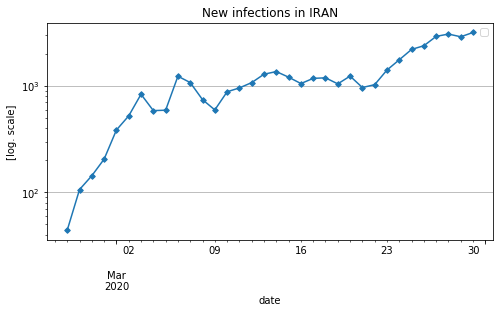

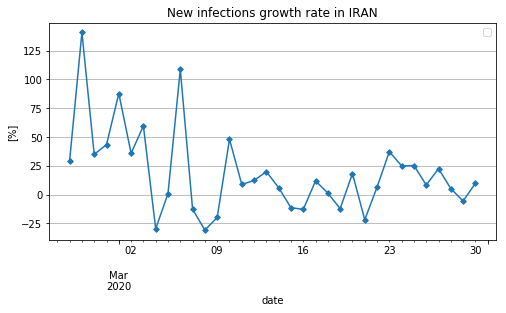

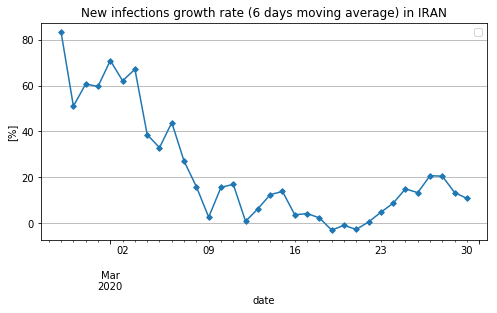

In [30]:
country = "iran"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])

## Turkey

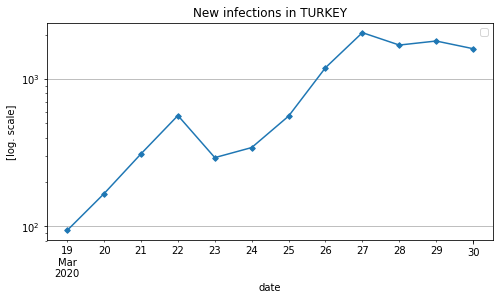

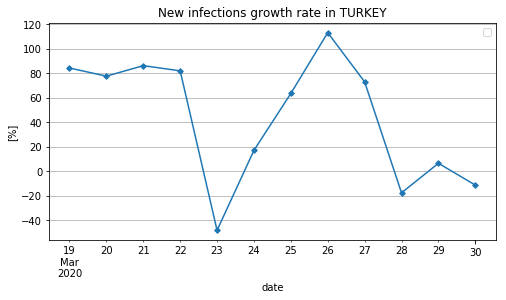

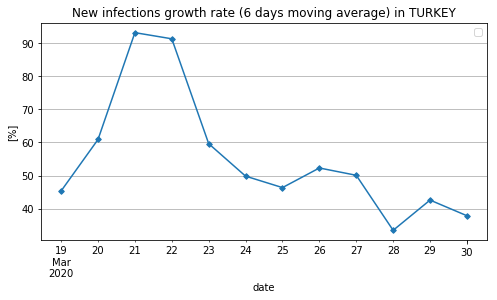

In [31]:
country = "turkey"
df_country = build_single_country_df(df_main, country)

for plt_i in range(len(param_list)):
    ts = plot_country_figures(df_country, 
                              log=param_list[plt_i]['log'], 
                              pct_change=param_list[plt_i]['pct_change'], 
                              rolling=param_list[plt_i]['rolling'])